# Calculus

In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import cm
import matplotlib as mp

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.3.0+cu118


### Gradients
The gradient of a function measures how much the output of the function changes if you change the inputs a little bit. For a scalar function f(x) of a single variable x, the gradient is its derivative df/dx. For a scalar function f(x_1, x_2, ..., x_n) of multiple variables (vecctor input x), the gradient is a vector of partial derivatives: ∇f(x) = [∂f/∂x_1, ∂f/∂x_2, ..., ∂f/∂x_n]. The gradient vector points in the direction of the steepest ascent of the function. The negative gradient (-∇f(x)) points in the direction of the steepest descent.

##### Manual Calculation for simple functions

In [2]:
# Example 1: f(x) = x^2
# Derivative: df/dx = 2x
def f1(x):
    return x**2

def df1_dx(x):
    return 2*x

x = torch.tensor(3.0, requires_grad=True)

In [6]:
y = f1(x)

In [7]:
y.backward()

In [9]:
y_manual = f1(x.item())
df1_manual = df1_dx(x.item())

In [10]:
y_torch = y.item()
df1_torch = x.grad.item()

In [12]:
torch.allclose(torch.tensor(df1_torch), torch.tensor(df1_manual))

True

In [21]:
# Example 2: f(x, y) = x^2 * y + y^3
# Partial derivatives:
# ∂f/∂x = 2xy
# ∂f/∂y = x^2 + 3y^2
def f2(x, y):
    return x**2 * y + y**3

def df2_dx(x, y):
    df_dx = 2 * x * y
    df_dy = x**2 + 3 * y**2
    return torch.tensor([df_dx, df_dy])

In [22]:
x1 = torch.tensor(3.0, requires_grad=True)
x2 = torch.tensor(4.0, requires_grad=True)

In [23]:
y = f2(x1, x2)

In [24]:
y.backward()

In [25]:
df2_manual = df2_dx(x1.item(), x2.item())

In [36]:
grad_x1 = x1.grad.item()
grad_x2 = x2.grad.item()

In [32]:
df2_torch = torch.tensor([grad_x1, grad_x2])

In [41]:
torch.allclose(df2_manual, df2_torch)

True

##### Numerical Approximation (Finite Differences)

We can approximate the derivative/gradient numerically using the definition: </br></br>
df/dx = (f(x+h) - f(x-h)) / 2h &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (Central difference, more accurate) </br>
or, df/dx = (f(x+h) - f(x-h)) / h  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (Forward difference) </br></br>
where h is small step size

In [42]:
def numerical_gradient_1d(func, x, h=1e-5):
    return (func(x + h) - func(x - h)) / (2 * h)

In [49]:
(numerical_gradient_1d(f1, x.item()),df1_torch)

(6.000000000039306, 6.0)

In [50]:
torch.allclose(torch.tensor(numerical_gradient_1d(f1, x.item())), torch.tensor(df1_torch))

True

In [66]:
def numerical_gradient_2d(func, x_vec, h=1e-5):
    grad = torch.zeros_like(x_vec)
    for i in range(x_vec.shape[0]):
        x_plus_h = x_vec.clone()
        x_plus_h[i] += h
        x_minus_h = x_vec.clone()
        x_minus_h[i] -= h 
        grad[i] = (func(x_plus_h[0], x_plus_h[1]) - func(x_minus_h[0], x_minus_h[1])) / (2 * h)
    return grad


In [67]:
numerical_gradient_2d(f2, torch.tensor([x1.item(),x2.item()]))

tensor([24.4141, 57.2205])

In [70]:
torch.allclose(numerical_gradient_2d(f2, torch.tensor([x1.item(),x2.item()])), df2_torch)

False

In [71]:
(numerical_gradient_2d(f2, torch.tensor([x1.item(),x2.item()])), df2_torch)

(tensor([24.4141, 57.2205]), tensor([24., 57.]))

While the differences may seem small, they can accumulate and impact model performance, especially in deep learning where we chain many operations together. </br>
*Note: Numerical gradients are useful for checking analytical gradients but are less precise and computationally expensive.*

##### *Why These Differences Matter*
In deep learning, these small gradient errors can compound and lead to:
- Error accumulation during backpropagation through many layers
- Optimization challenges where the optimizer follows slightly incorrect paths
- Convergence issues that may require more iterations or prevent reaching optimal solutions
- Numerical instability in certain architectures, especially those with many layers

##### Visualizing Gradients

In [84]:
plt.style.use('seaborn-v0_8-whitegrid')

function_color = '#1f77b4'    
tangent_color = '#ff7f0e'     
point_color = '#d62728'      
gradient_color = '#7f7f7f'   


In [85]:
# 1D Example: f(x) = x^2
x_range = np.linspace(-5, 5, 100)
y_f1 = f1(x_range)
y_df1 = df1_dx(x_range)

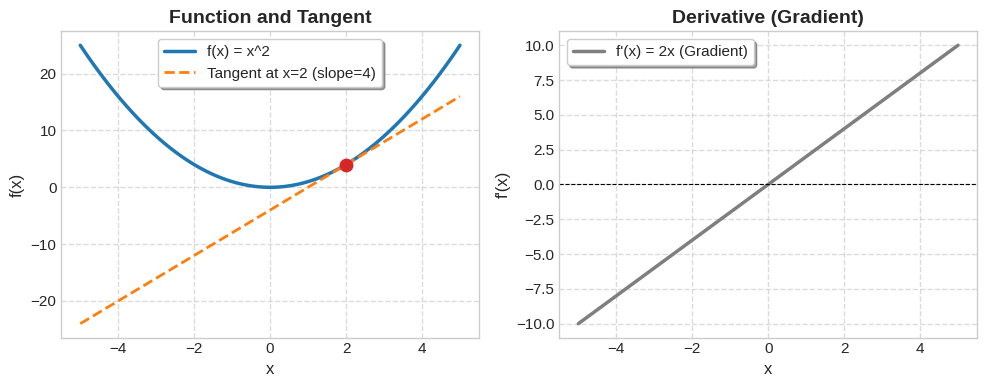

In [86]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, y_f1, color=function_color, linewidth=2.5, label='f(x) = x^2')

x_point = 2
y_point = f1(x_point)
slope_point = df1_dx(x_point)
tangent_line = slope_point * (x_range - x_point) + y_point

plt.plot(x_range, tangent_line, '--', color=tangent_color, linewidth=2, 
         label=f'Tangent at x={x_point} (slope={slope_point})')
plt.scatter([x_point], [y_point], color=point_color, s=80, zorder=5)

plt.title('Function and Tangent', fontsize=14, fontweight='bold')
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper center', frameon=True, fancybox=True, shadow=True)

plt.subplot(1, 2, 2)
plt.plot(x_range, y_df1, color=gradient_color, linewidth=2.5, label="f'(x) = 2x (Gradient)")
plt.axhline(0, color='black', lw=0.8, linestyle='--')

plt.title('Derivative (Gradient)', fontsize=14, fontweight='bold')
plt.xlabel('x', fontsize=12)
plt.ylabel("f'(x)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('1d_gradient_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [87]:
# 2D Example: f(x,y) = x^2 + y^2 (a simple paraboloid)
def f_paraboloid(x, y):
    return x**2 + y**2

def grad_f_paraboloid(x, y):
    return np.array([2*x, 2*y])

x_grid, y_grid = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
z_grid = f_paraboloid(x_grid, y_grid)

grad_x, grad_y = grad_f_paraboloid(x_grid, y_grid)

/tmp/ipykernel_1326267/195470375.py:34: UserWarning: Glyph 8711 (\N{NABLA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1326267/195470375.py:35: UserWarning: Glyph 8711 (\N{NABLA}) missing from current font.
  plt.savefig('2d_gradient_visualization.png', dpi=300, bbox_inches='tight')
/home/jung/anaconda3/envs/develop_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8711 (\N{NABLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


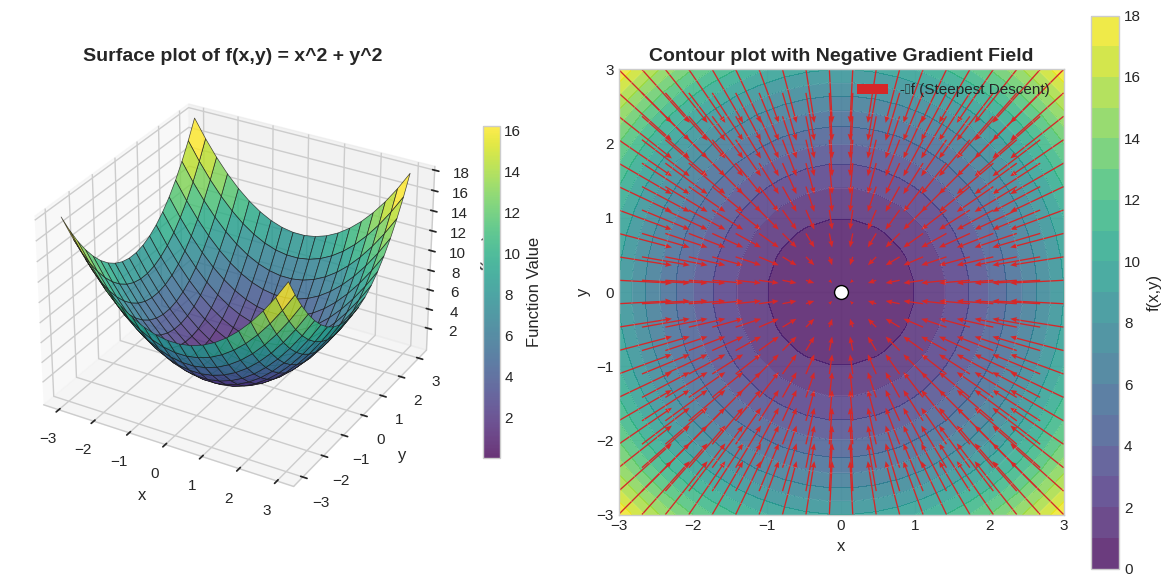

In [88]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8,
                        linewidth=0.5, edgecolor='k', antialiased=True)
ax1.set_title('Surface plot of f(x,y) = x^2 + y^2', fontsize=14, fontweight='bold')
ax1.set_xlabel('x', fontsize=12, labelpad=5)
ax1.set_ylabel('y', fontsize=12, labelpad=5)
ax1.set_zlabel('f(x,y)', fontsize=12, labelpad=5)
cbar = fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=20)
cbar.set_label('Function Value', fontsize=12)

ax2 = fig.add_subplot(122)
contour = ax2.contourf(x_grid, y_grid, z_grid, levels=20, cmap='viridis', alpha=0.8)
quiver = ax2.quiver(x_grid, y_grid, -grad_x, -grad_y, 
                    color=point_color, scale=50, headwidth=4, 
                    label='-∇f (Steepest Descent)')

contour_lines = ax2.contour(x_grid, y_grid, z_grid, 
                           levels=10, 
                           colors='white', 
                           alpha=0.3, 
                           linewidths=0.5)

ax2.scatter([0], [0], color='white', s=100, zorder=5, edgecolor='black')

fig.colorbar(contour, ax=ax2, label='f(x,y)')
ax2.set_title('Contour plot with Negative Gradient Field', fontsize=14, fontweight='bold')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.legend(loc='upper right')
ax2.axis('square')

plt.tight_layout()
plt.savefig('2d_gradient_visualization.png', dpi=300, bbox_inches='tight')
plt.show()